In [0]:
%matplotlib inline

# Multi layer perceptron from scratch - CIFAR10 dataset

**Reference:** https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

A neural network needs a few building blocks

- Dense layer - a fully-connected layer, $f(X)=W \cdot X + \vec{b}$
- ReLU layer (activation function to introduce non-linearity)
- Loss function (crossentropy in case of multi-class classification problem)
- Backprop algorithm - a stochastic gradient descent with backpropageted gradients

Let's approach them one at a time.

Let's start by importing some libraires required for creating our neural network.

In [0]:
from __future__ import print_function
import numpy as np ## For numerical python
np.random.seed(42)

Every layer will have a forward pass and backpass implementation. Let's create a main class layer which can do a forward pass .forward() and Backward pass .backward().

In [0]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:

    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here we can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, we need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, we already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If our layer has parameters (e.g. dense layer), we also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

### Nonlinearity ReLU layer

This is the simplest layer you can get: it simply applies a nonlinearity to each element of your network.

In [0]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        relu_forward = np.maximum(0,input)
        return relu_forward
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad = input > 0
        return grad_output*relu_grad 

### Dense layer

Now let's build something more complicated. Unlike nonlinearity, a dense layer actually has something to learn.

A dense layer applies affine transformation. In a vectorized form, it can be described as:
$$f(X)= W \cdot X + \vec b $$

Where 
* X is an object-feature matrix of shape [batch_size, num_features],
* W is a weight matrix [num_features, num_outputs] 
* and b is a vector of num_outputs biases.

Both W and b are initialized during layer creation and updated each time backward is called. Note that we are using **Xavier initialization** which is a trick to train our model to converge faster [read more](http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization). Instead of initializing our weights with small numbers which are distributed randomly we initialize our weights with mean zero and variance of 2/(number of inputs + number of outputs)

In [0]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, 
                                        scale = np.sqrt(2/(input_units+output_units)), 
                                        size = (input_units,output_units))
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input,self.weights) + self.biases
    
    def backward(self,input,grad_output):
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T)
        
        # compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Here we perform a stochastic gradient descent step. 
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

### The loss function

Since we want to predict probabilities, it would be logical for us to define softmax nonlinearity on top of our network and compute loss given predicted probabilities. However, there is a better way to do so.

If we write down the expression for crossentropy as a function of softmax logits (a), you'll see:

$$ loss = - log \space {e^{a_{correct}} \over {\underset i \sum e^{a_i} } } $$

If we take a closer look, we'll see that it can be rewritten as:

$$ loss = - a_{correct} + log {\underset i \sum e^{a_i} } $$

It's called Log-softmax and it's better than naive log(softmax(a)) in all aspects:
* Better numerical stability
* Easier to get derivative right
* Marginally faster to compute

So why not just use log-softmax throughout our computation and never actually bother to estimate probabilities.

In [0]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

### Full network

Now let's combine what we've just built into a working neural network. We are going to use CIFAR10 data for our example. Fortunately, Keras already have it in the numpy array format, so let's import it!.

In [7]:
# Use torchvision.datasets.CIFAR10 instead of keras.datasets.cifar10.load_data()
import keras
import matplotlib.pyplot as plt
%matplotlib inline

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = load_dataset(flatten=True)

# TODO: Show images using imshow(torchvision.utils.make_grid(images))

Using TensorFlow backend.


170500096/170498071 [==============================] - 5s 0us/step


We'll define network as a list of layers, each applied on top of previous one. In this setting, computing predictions and training becomes trivial.

In [0]:
network = []
network.append(Dense(X_train.shape[1],100))
network.append(ReLU())
network.append(Dense(100,200))
network.append(ReLU())
network.append(Dense(200,10))

In [0]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    """
    activations = []
    input = X

    # Looping through each layer
    for l in network:
        activations.append(l.forward(input))
        # Updating input to last layer output
        input = activations[-1]
    
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions. Returning indices of largest Logit probability
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train our network on a given batch of X and y.
    We first need to run forward to get all layer activations.
    Then we can run layer.backward going from last to first layer.
    After we have called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations  #layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    # Propagate gradients through the network
    # Reverse propogation as this is backprop
    for layer_index in range(len(network))[::-1]:
        layer = network[layer_index]
        
        loss_grad = layer.backward(layer_inputs[layer_index],loss_grad) #grad w.r.t. input, also weight updates
        
    return np.mean(loss)

### Training loop

We split data into minibatches, feed each such minibatch into the network and update weights. This training method is called a mini-batch stochastic gradient descent.

In [0]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [0]:
def get_network(input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], print_network=False):
    if print_network:
        print('\tNETWORK: Multi layer perceptron')
    network = []
    network.append(Dense(input_units, dense_output_units[0], learning_rate))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(input_units, dense_output_units[0], learning_rate))
    network.append(ReLU())
    if print_network:
        print('\t\tReLU()')
    
    for i, _ in enumerate(dense_output_units):
      if i == len(dense_output_units) - 1:
        break
      network.append(Dense(dense_output_units[i], dense_output_units[i+1], learning_rate))
      if print_network:
          print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[i], dense_output_units[i+1], learning_rate))
      network.append(ReLU())
      if print_network:
          print('\t\tReLU()')
    
    network.append(Dense(dense_output_units[-1], output_units))
    if print_network:
        print('\t\tDense(input_units={}, output_units={}, learning_rate={})'.format(dense_output_units[-1], output_units, learning_rate))

    return network

In [0]:
from IPython.display import clear_output
from time import time

def training_loop(network, input_units, output_units, learning_rate=0.1, epochs=25, dense_output_units=[100, 200], batchsize=32, shuffle=True):
    if len(dense_output_units) < 2:
      return

    epoch_start = time()
    train_acc_list = []
    test_acc_list = []
    epoch_time_list = []

    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=batchsize,shuffle=shuffle):
            train(network,x_batch,y_batch)
        
        train_acc_list.append(np.mean(predict(network,X_train)==y_train))
        test_acc_list.append(np.mean(predict(network,X_test)==y_test))
        
        clear_output()
        print("Epoch", epoch)
        print("Training accuracy: {:.2f}%".format(train_acc_list[-1]*100))
        print("Test accuracy: {:.2f}%".format(test_acc_list[-1]*100))
        epoch_time = time() - epoch_start
        epoch_time_list.append(epoch_time)
        print("Epoch's processing time: {:.2f} seconds".format(epoch_time))
        plt.plot(train_acc_list, label='train accuracy')
        plt.plot(test_acc_list, label='test accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
    
    return train_acc_list, test_acc_list, epoch_time_list

## Testing different dense layers

* Using 2 dense layers with learning_rate=0.1 (100 and 200 output units). Minibatches: batchsize=32, shuffle=True

* Using 3 dense layers with learning_rate=0.1 (100, 200, and 300 output units). Minibatches: batchsize=32, shuffle=True

* Using 4 dense layers with learning_rate=0.1 (100, 200, 300 and 400 output units). Minibatches: batchsize=32, shuffle=True

* Using 5 dense layers with learning_rate=0.1 (100, 200, 300, 400, and 500 output units). Minibatches: batchsize=32, shuffle=True

In [0]:
test_accuracy_list = []

In [0]:
from time import time
import numpy as np

def mlp_training(network, input_units, output_units, learning_rate, epochs, dense_output_units, batchsize, shuffle):
    training_start = time()
    train_acc_list, test_acc_list, epoch_time_list = training_loop(network, input_units=input_units, output_units=output_units, learning_rate=learning_rate, epochs=epochs, dense_output_units=dense_output_units, batchsize=batchsize, shuffle=shuffle)
    print("Total time: {} seconds".format(time() - training_start))

    labels = ['epoch {}'.format(str(i).zfill(3)) for i in range(epochs)]

    train_acc_np = np.asarray(train_acc_list)
    print("\nTraining accuracy list: {}".format(train_acc_np))
    print("Training accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (train_acc_np.mean()*100, train_acc_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in train_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Training accuracy per epoch', use_xlim=True)

    test_acc_np = np.asarray(test_acc_list)
    print("\nTest accuracy list: {}".format(test_acc_np))
    print("Test accuracy (Mean +/- Std): %0.2f (+/- %0.2f)" % (test_acc_np.mean()*100, test_acc_np.std() * 2))

    # Save test accuracy to plotting: Test accuracy Vs Number of dense layers
    test_accuracy_list.append(test_acc_np.mean()*100)

    # Plot horizontal bar
    values = [v * 100 for v in test_acc_list]
    plot_horizontal_bar(labels, values, xlabel='Accuracy', ylabel='', title='Test accuracy per epoch', use_xlim=True)

    epoch_time_np = np.asarray(epoch_time_list)
    print("\nEpoch time list: {}".format(epoch_time_np))
    print("Epoch time (Mean +/- Std): %0.2f (+/- %0.2f)" % (epoch_time_np.mean(), epoch_time_np.std() * 2))
    # Plot horizontal bar
    values = [v * 100 for v in epoch_time_list]
    plot_horizontal_bar(labels, values, xlabel='Time', ylabel='', title='Epoch time in seconds', use_xlim=False)

In [0]:
def plot_horizontal_bar(x, y, xlabel, ylabel, title, use_xlim=False):
    fig, ax = plt.subplots()    
    width = 0.75 # the width of the bars 
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="blue")
    ax.set_yticks(ind+width/2)
    ax.set_yticklabels(x, minor=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)      

    for i, v in enumerate(y):
        ax.text(v + 3, i + .25, '%0.2f'%(v), color='blue', fontweight='bold')
    
    if use_xlim:
        plt.xlim(0, 120)
        plt.tight_layout()
    
    plt.show()

### Using **2 dense layers** (100 and 200 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [16]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 509.33 seconds


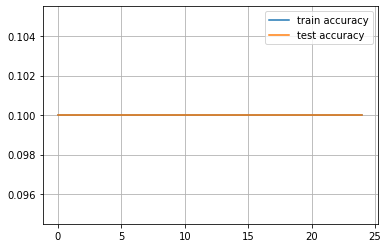

Total time: 509.48499822616577 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


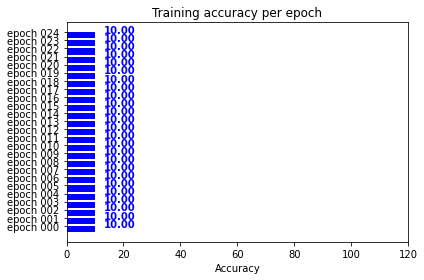


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


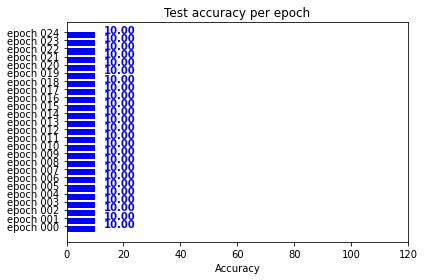


Epoch time list: [ 21.69229198  41.99359608  62.28916645  82.34716439 102.32106066
 122.40735245 142.43514943 162.44249773 182.45868206 202.8766973
 223.25736356 243.51750183 263.79452372 283.99046659 304.50275588
 324.72149014 345.05722404 365.2124157  385.52578902 405.66811728
 426.19335175 446.61660004 466.516397   489.00160956 509.33328605]
Epoch time (Mean +/- Std): 264.25 (+/- 292.38)


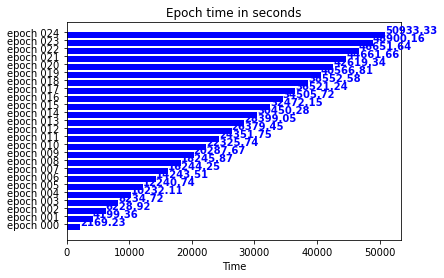

In [17]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **3 dense layers** (100, 200 and 300 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [18]:
dense_output_units=[100, 200, 300]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 599.56 seconds


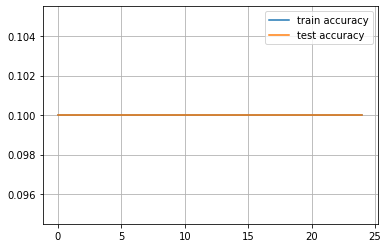

Total time: 599.7084605693817 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


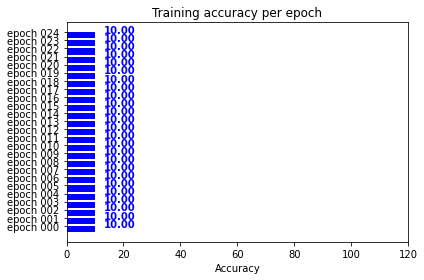


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


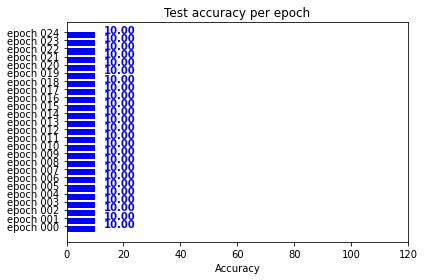


Epoch time list: [ 23.30301523  46.74015808  70.8371141   94.50214553 118.05917954
 141.39059854 165.66199398 189.91013646 214.43993497 238.90390205
 263.04093027 287.29913664 311.70559669 336.06700301 360.1012516
 384.56677151 408.87040186 433.04979873 457.35988879 481.63937807
 504.52860069 527.70005774 551.19454455 576.17424822 599.5636704 ]
Epoch time (Mean +/- Std): 311.46 (+/- 347.67)


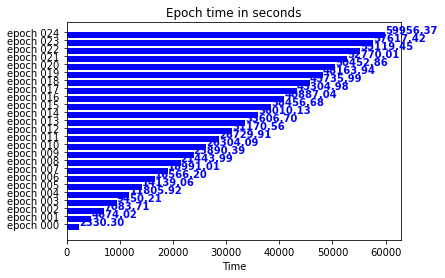

In [19]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **4 dense layers** (100, 200, 300 and 400 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [20]:
dense_output_units=[100, 200, 300, 400]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		ReLU()
		Dense(input_units=400, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 707.78 seconds


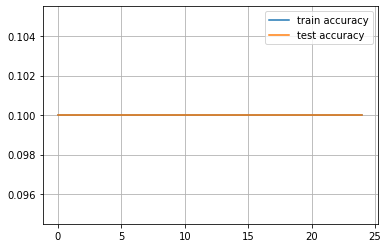

Total time: 707.9355335235596 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


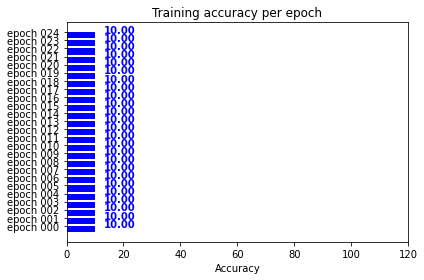


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


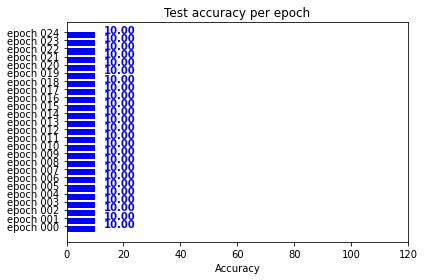


Epoch time list: [ 27.52026176  55.09511256  83.18319154 111.01045394 138.65954638
 166.49296427 194.68409252 222.94933438 251.46889281 279.74805117
 308.17313218 336.4186058  364.25568318 392.63264441 421.19119811
 449.38852358 477.39167595 505.54173875 533.8510828  562.31450725
 592.85899901 621.49924469 650.35392666 678.9693048  707.78329206]
Epoch time (Mean +/- Std): 365.34 (+/- 408.70)


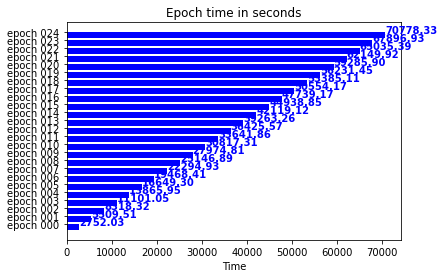

In [21]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using **5 dense layers** (100, 200, 300, 400 and 500 output units) with learning_rate=0.1 . Minibatches: batchsize=32, shuffle=True

In [22]:
dense_output_units=[100, 200, 300, 400, 500]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=300, learning_rate=0.1)
		ReLU()
		Dense(input_units=300, output_units=400, learning_rate=0.1)
		ReLU()
		Dense(input_units=400, output_units=500, learning_rate=0.1)
		ReLU()
		Dense(input_units=500, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 906.11 seconds


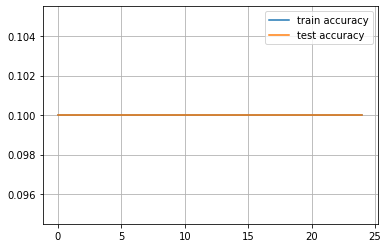

Total time: 906.2583861351013 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


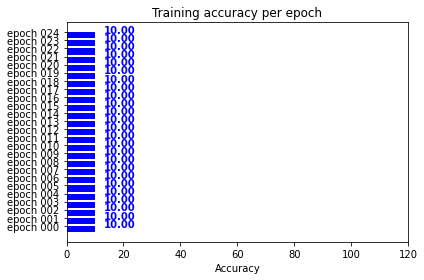


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


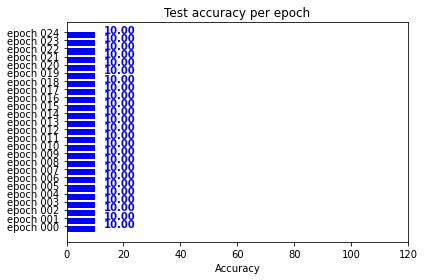


Epoch time list: [ 36.01253843  72.0033505  108.14329028 144.16665149 180.31855392
 216.39879346 252.48583484 288.89190245 325.36577106 361.87506604
 397.7797842  433.74452782 469.80045319 508.1750679  544.02547669
 580.04940605 616.17053056 651.05859089 685.86626959 722.83862233
 759.76774693 796.46030903 832.8095572  869.46615028 906.11297965]
Epoch time (Mean +/- Std): 470.39 (+/- 522.61)


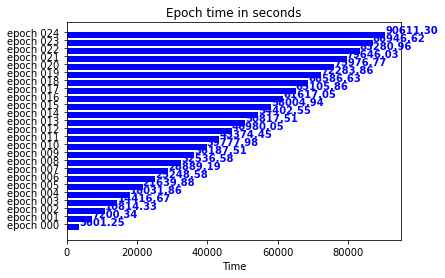

In [23]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best number of dense layers

* Highest test accuracy (mean)

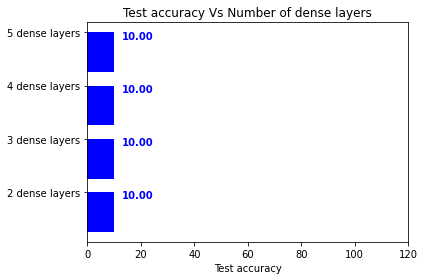

In [24]:
labels = ['2 dense layers', '3 dense layers', '4 dense layers', '5 dense layers']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Number of dense layers', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different learning rates

* Using 2 dense layers with learning_rate = 0.1. Minibatches: batchsize=32, shuffle=True

* Using 2 dense layers with learning_rate = 0.01. Minibatches: batchsize=32, shuffle=True

* Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

* Using 2 dense layers with learning_rate = 0.0001. Minibatches: batchsize=32, shuffle=True

In [32]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


### Using 2 dense layers with **learning_rate = 0.1**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 520.37 seconds


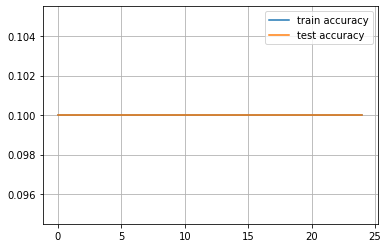

Total time: 520.5127177238464 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


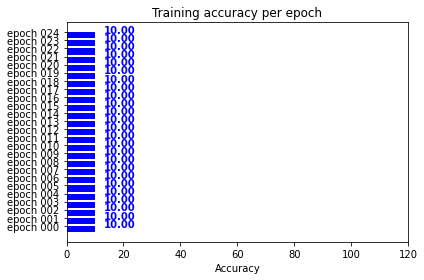


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


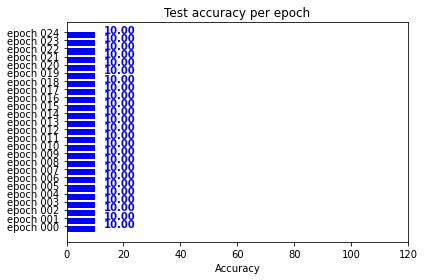


Epoch time list: [ 21.19876385  42.16844797  62.98453617  84.2228415  105.24542022
 126.31914234 147.28568339 168.29849243 189.32782292 210.41573572
 233.54345751 254.54364491 275.47283459 296.68512774 317.67666841
 337.8677392  358.16503167 378.5915029  399.1332705  419.33696842
 439.58169436 459.75320029 480.00684667 500.17976117 520.3692317 ]
Epoch time (Mean +/- Std): 273.13 (+/- 301.05)


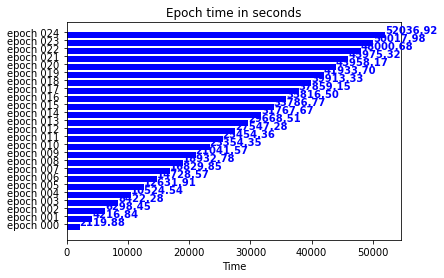

In [33]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.1, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 2 dense layers with **learning_rate = 0.01**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 505.98 seconds


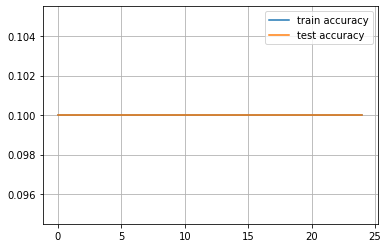

Total time: 506.135285615921 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


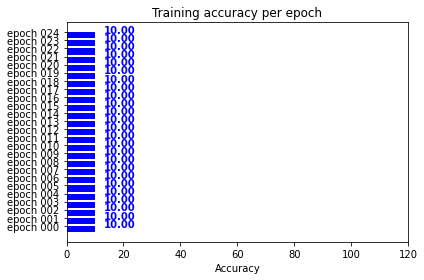


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


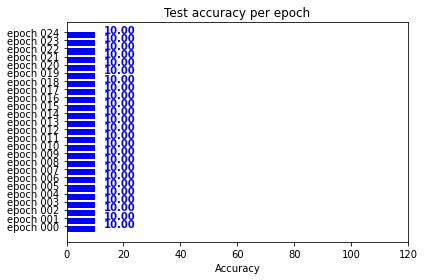


Epoch time list: [ 19.92571115  40.15590072  60.3281312   80.53039503 100.74788666
 120.94026613 141.19860458 161.33736277 181.66277146 201.81175709
 221.96942377 242.18108106 262.36891079 282.53776646 302.70217037
 324.95002222 344.82211399 364.91454864 385.01677227 405.07365346
 425.26863599 445.44245982 465.51917982 485.68301988 505.97879672]
Epoch time (Mean +/- Std): 262.92 (+/- 292.43)


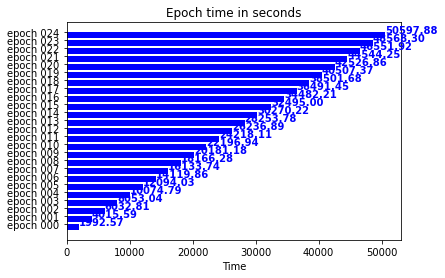

In [34]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.01, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 2 dense layers with **learning_rate = 0.001**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 508.91 seconds


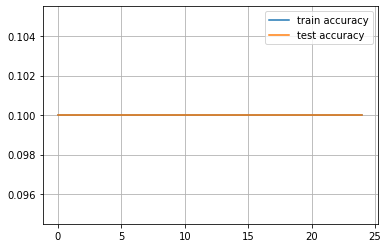

Total time: 509.06941294670105 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


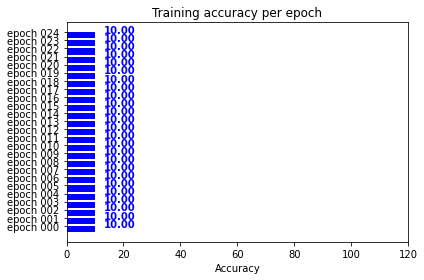


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


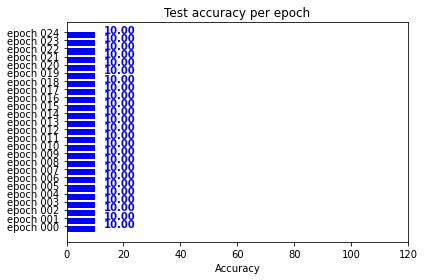


Epoch time list: [ 20.50690866  41.25646138  61.53900218  81.45620537 101.63653636
 121.56775403 141.81973624 161.9822185  182.03756666 202.13713551
 222.48106265 242.87892532 263.19235325 283.54025602 303.95986032
 324.15157509 344.27126431 364.52283454 384.68570495 405.00645065
 427.11266756 447.24206686 467.39073324 488.1494081  508.91497326]
Epoch time (Mean +/- Std): 263.74 (+/- 292.93)


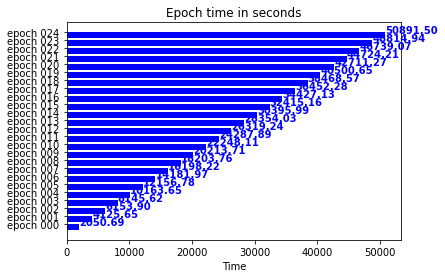

In [35]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 2 dense layers with **learning_rate = 0.0001**. Minibatches: batchsize=32, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 520.62 seconds


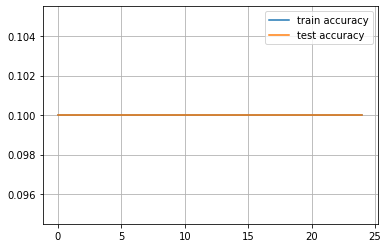

Total time: 520.7640943527222 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


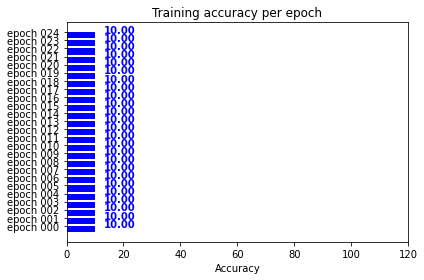


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


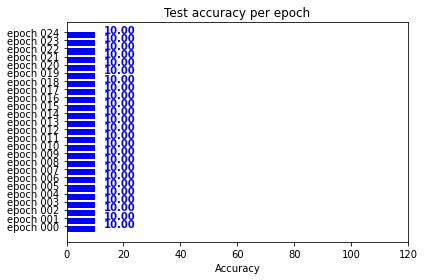


Epoch time list: [ 20.74571586  41.75523043  62.76149988  83.6367445  104.78000855
 125.59285903 146.67539096 167.75744176 188.83073545 209.91222787
 230.85791421 251.80160809 272.747329   293.6554358  314.48038054
 335.3884275  356.13544464 377.05056691 397.36559677 417.61993885
 437.85974193 458.05760264 478.19520688 498.31909132 520.61658192]
Epoch time (Mean +/- Std): 271.70 (+/- 300.20)


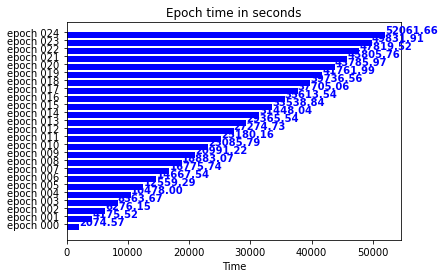

In [36]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.0001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

## Best learning rate

* Highest test accuracy (mean)

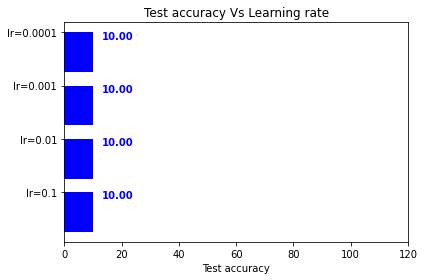

In [37]:
labels = ['lr=0.1', 'lr=0.01', 'lr=0.001', 'lr=0.0001']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Learning rate', use_xlim=True)

In [0]:
test_accuracy_list = []

## Testing different batch size

* Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=8, shuffle=True

* Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=16, shuffle=True

* Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=32, shuffle=True

* Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=64, shuffle=True

* Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=128, shuffle=True

In [39]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


### Using 2 dense layers with learning_rate = 0.001. Minibatches: **batchsize=8**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 899.94 seconds


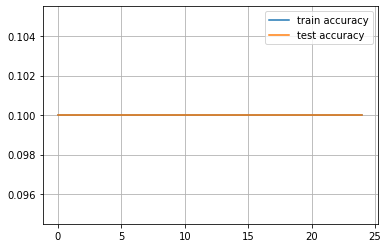

Total time: 900.0865120887756 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


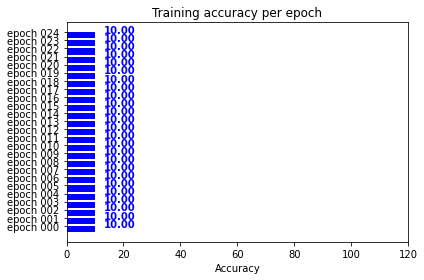


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


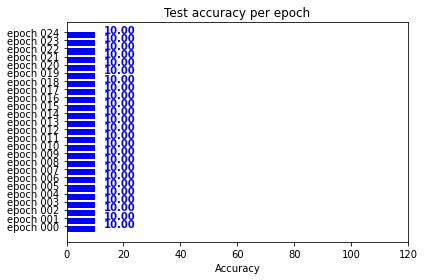


Epoch time list: [ 35.24747825  70.68074894 105.95459557 141.68639946 177.79731417
 214.42231274 251.11461306 287.39487648 323.5931406  359.46968961
 394.93696475 430.80080962 466.78387618 502.42327213 538.25843215
 574.243891   612.87559557 648.87207174 684.4425211  720.56183863
 756.46967673 792.12545562 828.25027514 864.00338292 899.93675756]
Epoch time (Mean +/- Std): 467.29 (+/- 520.52)


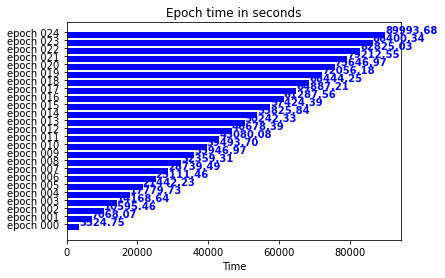

In [40]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=8, shuffle=True)

### Using 2 dense layers with learning_rate = 0.001. Minibatches: **batchsize=16**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 636.38 seconds


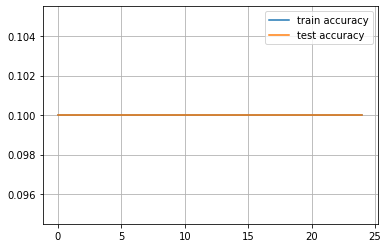

Total time: 636.5294721126556 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


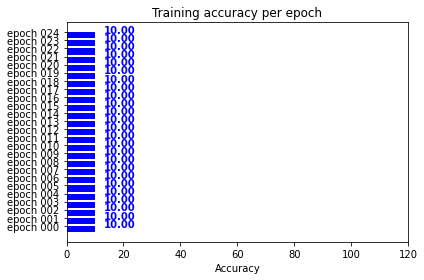


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


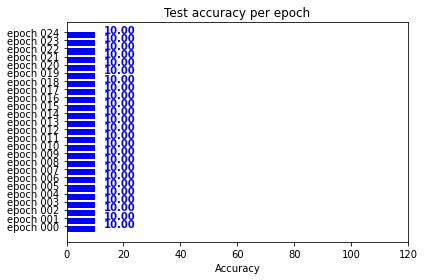


Epoch time list: [ 26.30551577  52.57455325  78.27742696 103.82155299 129.03063774
 154.45944786 179.87621498 205.2295022  230.64177823 256.16030121
 281.42778254 308.33559227 333.51690054 358.66998672 383.74482536
 408.97000384 433.94231606 458.96851063 483.91188884 508.85331583
 534.29947686 559.72963619 584.89217091 610.13588071 636.38452244]
Epoch time (Mean +/- Std): 332.09 (+/- 365.73)


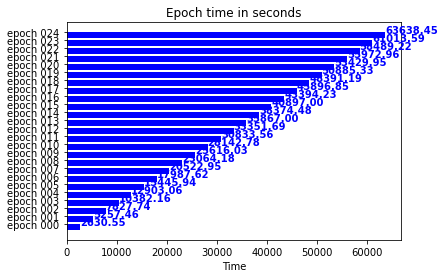

In [41]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=16, shuffle=True)

### Using 2 dense layers with learning_rate = 0.001. Minibatches: **batchsize=32**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 521.67 seconds


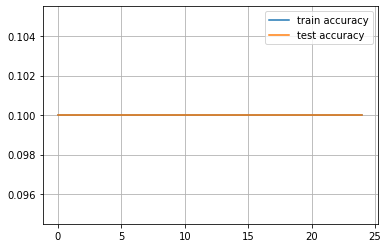

Total time: 521.8224945068359 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


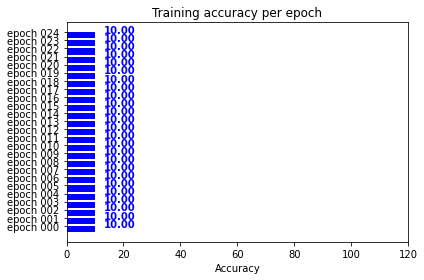


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


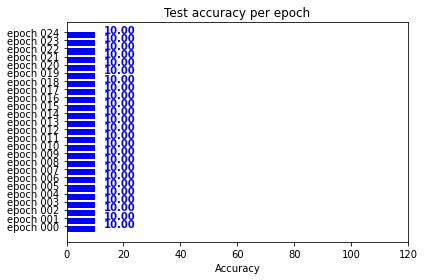


Epoch time list: [ 20.98557711  42.16847515  63.49003172  84.62428689 105.58239412
 126.49675846 147.37167978 168.65055394 189.63702416 210.68854451
 231.95245147 252.94501948 273.82859898 297.05495524 317.99071479
 338.7252121  359.68077779 380.57250953 400.83236504 420.99964666
 441.10230327 461.30045199 481.41232872 501.45298743 521.66977906]
Epoch time (Mean +/- Std): 273.65 (+/- 302.17)


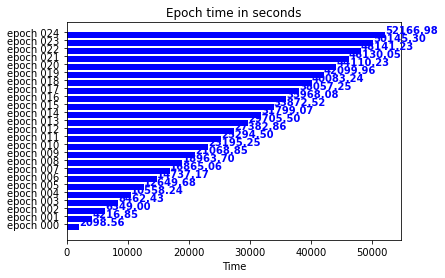

In [42]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=32, shuffle=True)

### Using 2 dense layers with learning_rate = 0.001. Minibatches: **batchsize=64**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 439.64 seconds


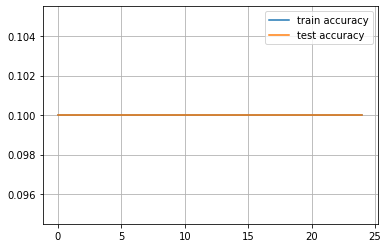

Total time: 439.7839684486389 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


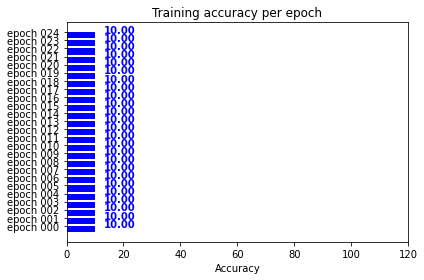


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


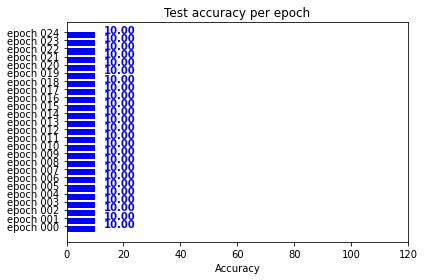


Epoch time list: [ 17.55190778  35.26977372  52.79741335  70.36161971  87.98055148
 105.54804134 123.20882297 140.82377052 158.39519191 175.9092586
 193.48863554 210.87277913 228.2431767  245.7036891  263.16802144
 280.66852856 298.1064527  315.77681851 333.24088025 350.69552732
 369.69821978 387.29339194 404.8136127  422.2425108  439.63628507]
Epoch time (Mean +/- Std): 228.46 (+/- 253.46)


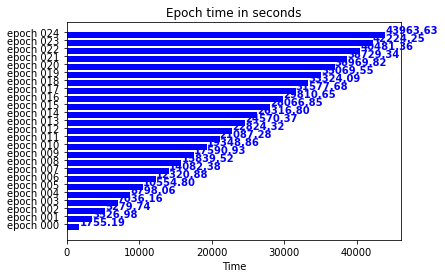

In [43]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=64, shuffle=True)

### Using 2 dense layers with learning_rate = 0.001. Minibatches: **batchsize=128**, shuffle=True

Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 401.76 seconds


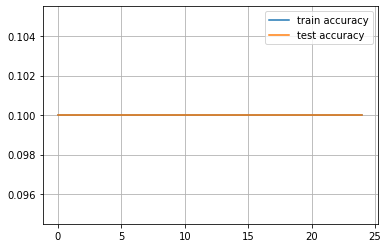

Total time: 401.9105520248413 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


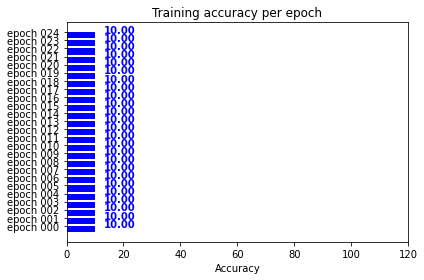


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


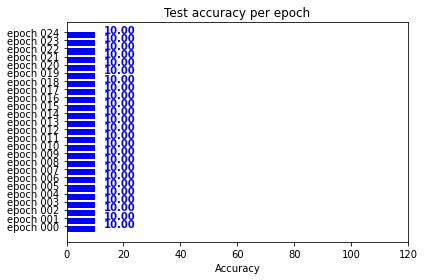


Epoch time list: [ 15.92914152  31.9259665   47.95608735  64.2332108   80.36227584
  96.5069344  112.62470675 128.70356059 144.6404736  160.77595425
 176.8624146  192.95718217 209.02108002 225.11624479 241.16920614
 257.20868039 273.17826867 289.26438403 305.44686818 321.50466347
 337.52720833 353.57494736 369.66020489 385.74255514 401.76247597]
Epoch time (Mean +/- Std): 208.95 (+/- 231.86)


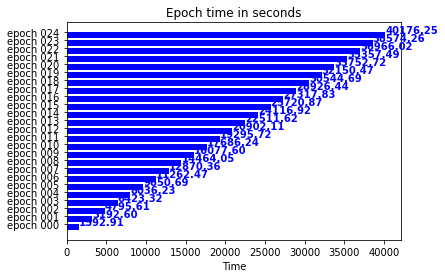

In [44]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=128, shuffle=True)

## Best batch size

* Highest test accuracy (mean)

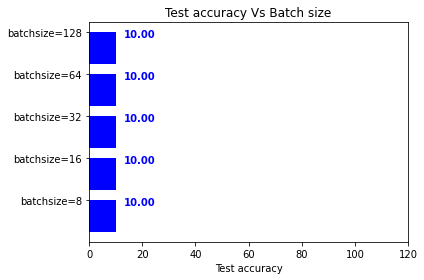

In [45]:
labels = ['batchsize=8', 'batchsize=16', 'batchsize=32', 'batchsize=64', 'batchsize=128']
plot_horizontal_bar(labels, test_accuracy_list, xlabel='Test accuracy', ylabel='', title='Test accuracy Vs Batch size', use_xlim=True)

## Conclusion: Best MLP model

### Using 2 dense layers with learning_rate = 0.001. Minibatches: batchsize=64, shuffle=True

In [46]:
dense_output_units=[100, 200]

network = get_network(input_units=X_train.shape[1], output_units=10, epochs=25, dense_output_units=dense_output_units, print_network=True)

	NETWORK: Multi layer perceptron
		Dense(input_units=3072, output_units=100, learning_rate=0.1)
		ReLU()
		Dense(input_units=100, output_units=200, learning_rate=0.1)
		ReLU()
		Dense(input_units=200, output_units=10, learning_rate=0.1)


Epoch 24
Training accuracy: 10.00%
Test accuracy: 10.00%
Epoch's processing time: 442.52 seconds


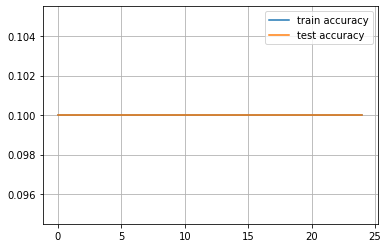

Total time: 442.6643898487091 seconds

Training accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Training accuracy (Mean +/- Std): 10.00 (+/- 0.00)


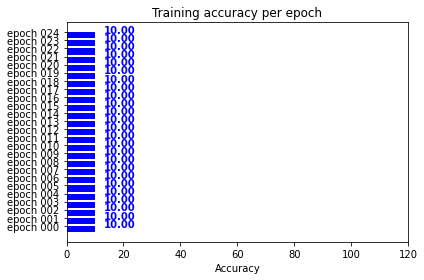


Test accuracy list: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Test accuracy (Mean +/- Std): 10.00 (+/- 0.00)


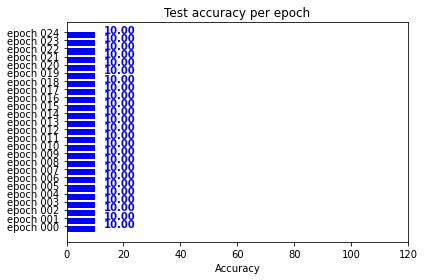


Epoch time list: [ 17.35883999  34.79683399  52.27581072  69.81087327  87.76048231
 105.40498424 123.10335779 142.89925003 160.57490706 178.1254282
 195.82070971 213.33383942 230.81307435 248.23863912 265.89908743
 283.46846175 301.24031067 319.02588034 336.51519346 354.31466985
 371.99983454 389.60331917 407.38711691 425.00449514 442.52257419]
Epoch time (Mean +/- Std): 230.29 (+/- 255.77)


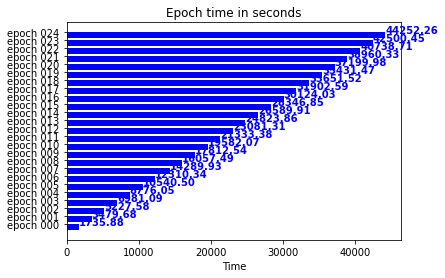

In [47]:
mlp_training(network, input_units=X_train.shape[1], output_units=10, learning_rate=0.001, epochs=25, dense_output_units=dense_output_units, batchsize=64, shuffle=True)